In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()


In [10]:
def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

Fastprop performance on Leeds

In [6]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_absolute_performance_results", "fastprop")
leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_predictions.csv"))

leeds_all = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

Fastprop Krasnov performance

In [13]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_absolute_performance_results", "fastprop")
training_performance: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "bigsoldb_downsample_predictions.csv"))
mse_training, percentage_within_1_unit_training = stats(training_performance['logS_true'], training_performance['logS_pred'])
print("MSE Krasnov training= " + f"{np.sqrt(mse_training)}", 
      "\nPercentage within 1 logS for Training = " + f"{percentage_within_1_unit_training}")

MSE Krasnov training= 0.6135417049621151 
Percentage within 1 logS for Training = 90.72914217310446


Label distributions

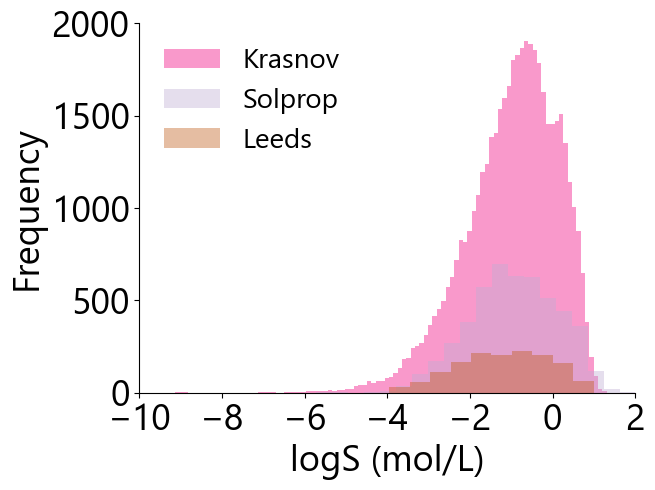

In [27]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results\final_results", "custom")
solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_predictions.csv"))
training_performance['logS_true'].plot(kind='hist', bins=120, color = colors[5], alpha = 0.4, label = 'Krasnov')
solprop['logS_true'].plot(kind='hist', bins=20, alpha = 0.4, color = colors[1], label = 'Solprop')
leeds_all['logS_true'].plot(kind='hist', bins=10, alpha = 0.4, color = colors[6], label = 'Leeds')

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("logS (mol/L)")
plt.xlim([-10, 2])
plt.xticks([-10, -8, -6, -4, -2, 0, 2 ])
plt.legend(prop={'size': 20}, loc = 'upper left', frameon = False) 
#plt.ylim([-10, 1200])
#plt.yticks([0, 400, 800, 1200])

Venn Diagram of solute overlap

In [28]:
training_performance[['solvent', 'solute']] = training_performance['smiles'].str.split('.', expand=True)
unique_solutes_krasnov = training_performance['solute'].unique()
print(len(unique_solutes_krasnov))

solprop[['solvent', 'solute']] = solprop['smiles'].str.split('.', expand=True, n=1)
unique_solutes_solprop = solprop['solute'].unique()
print(len(unique_solutes_solprop))

leeds_all[['solvent', 'solute']] = leeds_all['smiles'].str.split('.', expand=True)
unique_solutes_leeds = leeds_all['solute'].unique()
print(len(unique_solutes_leeds))

704
100
1418


In [29]:
training_solutes = []
training_solvents = []
for training_set in (
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\AqueousSolu.csv"),
        Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolv-Exp.csv"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolv-QM.txt"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolvH-Exp.csv"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolvH-QM.txt"),
):
    if training_set.suffix == "xlsx":
        df = pd.read_excel(training_set)
    else:
        df = pd.read_csv(training_set)
    if "Aqueous" in training_set.name:
        training_solutes.extend(df["smiles solute"])
    elif "QM" in training_set.name:
        training_solutes.extend(df["smiles solute"])
        training_solvents.extend(df["smiles solvent"])
    else:
        training_solutes.extend(df["smiles_solute"])
        training_solvents.extend(df["smiles_solvent"])

# cast to set twice - once to remove immediate dupes, again to remove
# multiple identical representations
training_solvents = set(Chem.CanonSmiles(s) for s in set(training_solvents))
training_solutes = set(Chem.CanonSmiles(s) for s in set(training_solutes))

[11:35:24] WARNING: not removing hydrogen atom without neighbors


In [30]:
overlapping_solutes = np.intersect1d(unique_solutes_krasnov, unique_solutes_leeds)
print(f"Overlap of Krasnov and Leeds solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_leeds):.2%} of test set.")

unique_solutes_solprop_training = np.array(list(training_solutes))
unique_solutes_solprop_training
overlapping_solutes = np.intersect1d(unique_solutes_solprop_training, unique_solutes_leeds)
print(f"Overlap of Solprop training and Leeds solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_leeds):.2%} of test set.")

overlapping_solutes = np.intersect1d(unique_solutes_krasnov, unique_solutes_solprop_training)
print(f"Overlap of Solprop training and Krasnov solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_solprop_training):.2%} of test set.")

overlapping_solutes = np.intersect1d(unique_solutes_krasnov, unique_solutes_solprop)
print(f"Overlap of Solprop testing and Krasnov solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_solprop):.2%} of test set.")

Overlap of Krasnov and Leeds solutes is 0, or 0.00% of test set.
Overlap of Solprop training and Leeds solutes is 78, or 5.50% of test set.
Overlap of Solprop training and Krasnov solutes is 350, or 1.71% of test set.
Overlap of Solprop testing and Krasnov solutes is 0, or 0.00% of test set.


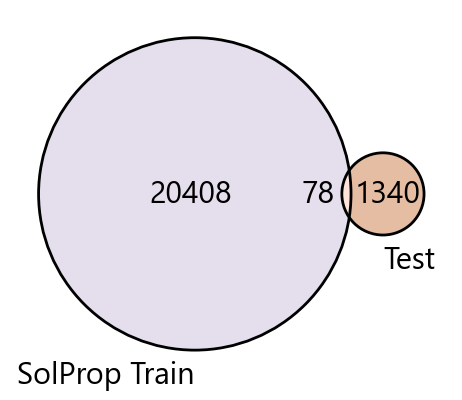

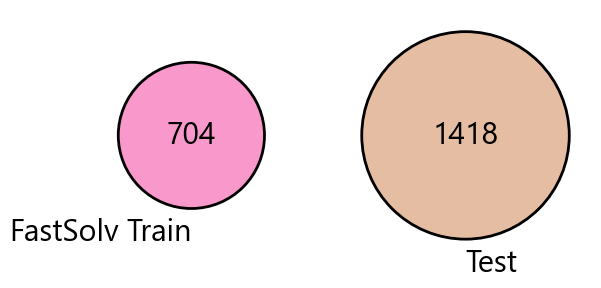

In [31]:
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

fig = venn2(
    [set(unique_solutes_solprop_training), set(unique_solutes_leeds)],
    ("SolProp Train", "Test"),
    set_colors = (colors[1], colors[6]),
    alpha = 0.4
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
    #subset_areas=(20, 23, 70, 23, 26, 0, 6),
)
venn2_circles([set(unique_solutes_solprop_training), set(unique_solutes_leeds)], linewidth=2)
lbl = fig.get_label_by_id("11")
fig.get_label_by_id("11").set_fontsize(22)
x,y = lbl.get_position()
lbl.set_position((x-0.1, y))
fig.get_label_by_id("A").set_fontsize(22)
fig.get_label_by_id("B").set_fontsize(22)
fig.get_label_by_id("01").set_fontsize(22)
fig.get_label_by_id("10").set_fontsize(22)
plt.show()

fig = venn2(
    [set(unique_solutes_krasnov), set(unique_solutes_leeds)],
    ("FastSolv Train", "Test"),
    set_colors = (colors[5], colors[6]),
    alpha = 0.4
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
    #subset_areas=(20, 23, 70, 23, 26, 0, 6),
)
venn2_circles([set(unique_solutes_krasnov), set(unique_solutes_leeds)], linewidth=2)
fig.get_label_by_id("A").set_fontsize(22)
fig.get_label_by_id("B").set_fontsize(22)
fig.get_label_by_id("01").set_fontsize(22)
fig.get_label_by_id("10").set_fontsize(22)

plt.show()

Plotting all together for Figure 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_26400\4128569786.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels([-8, -6, -4, -2, 0, 2])


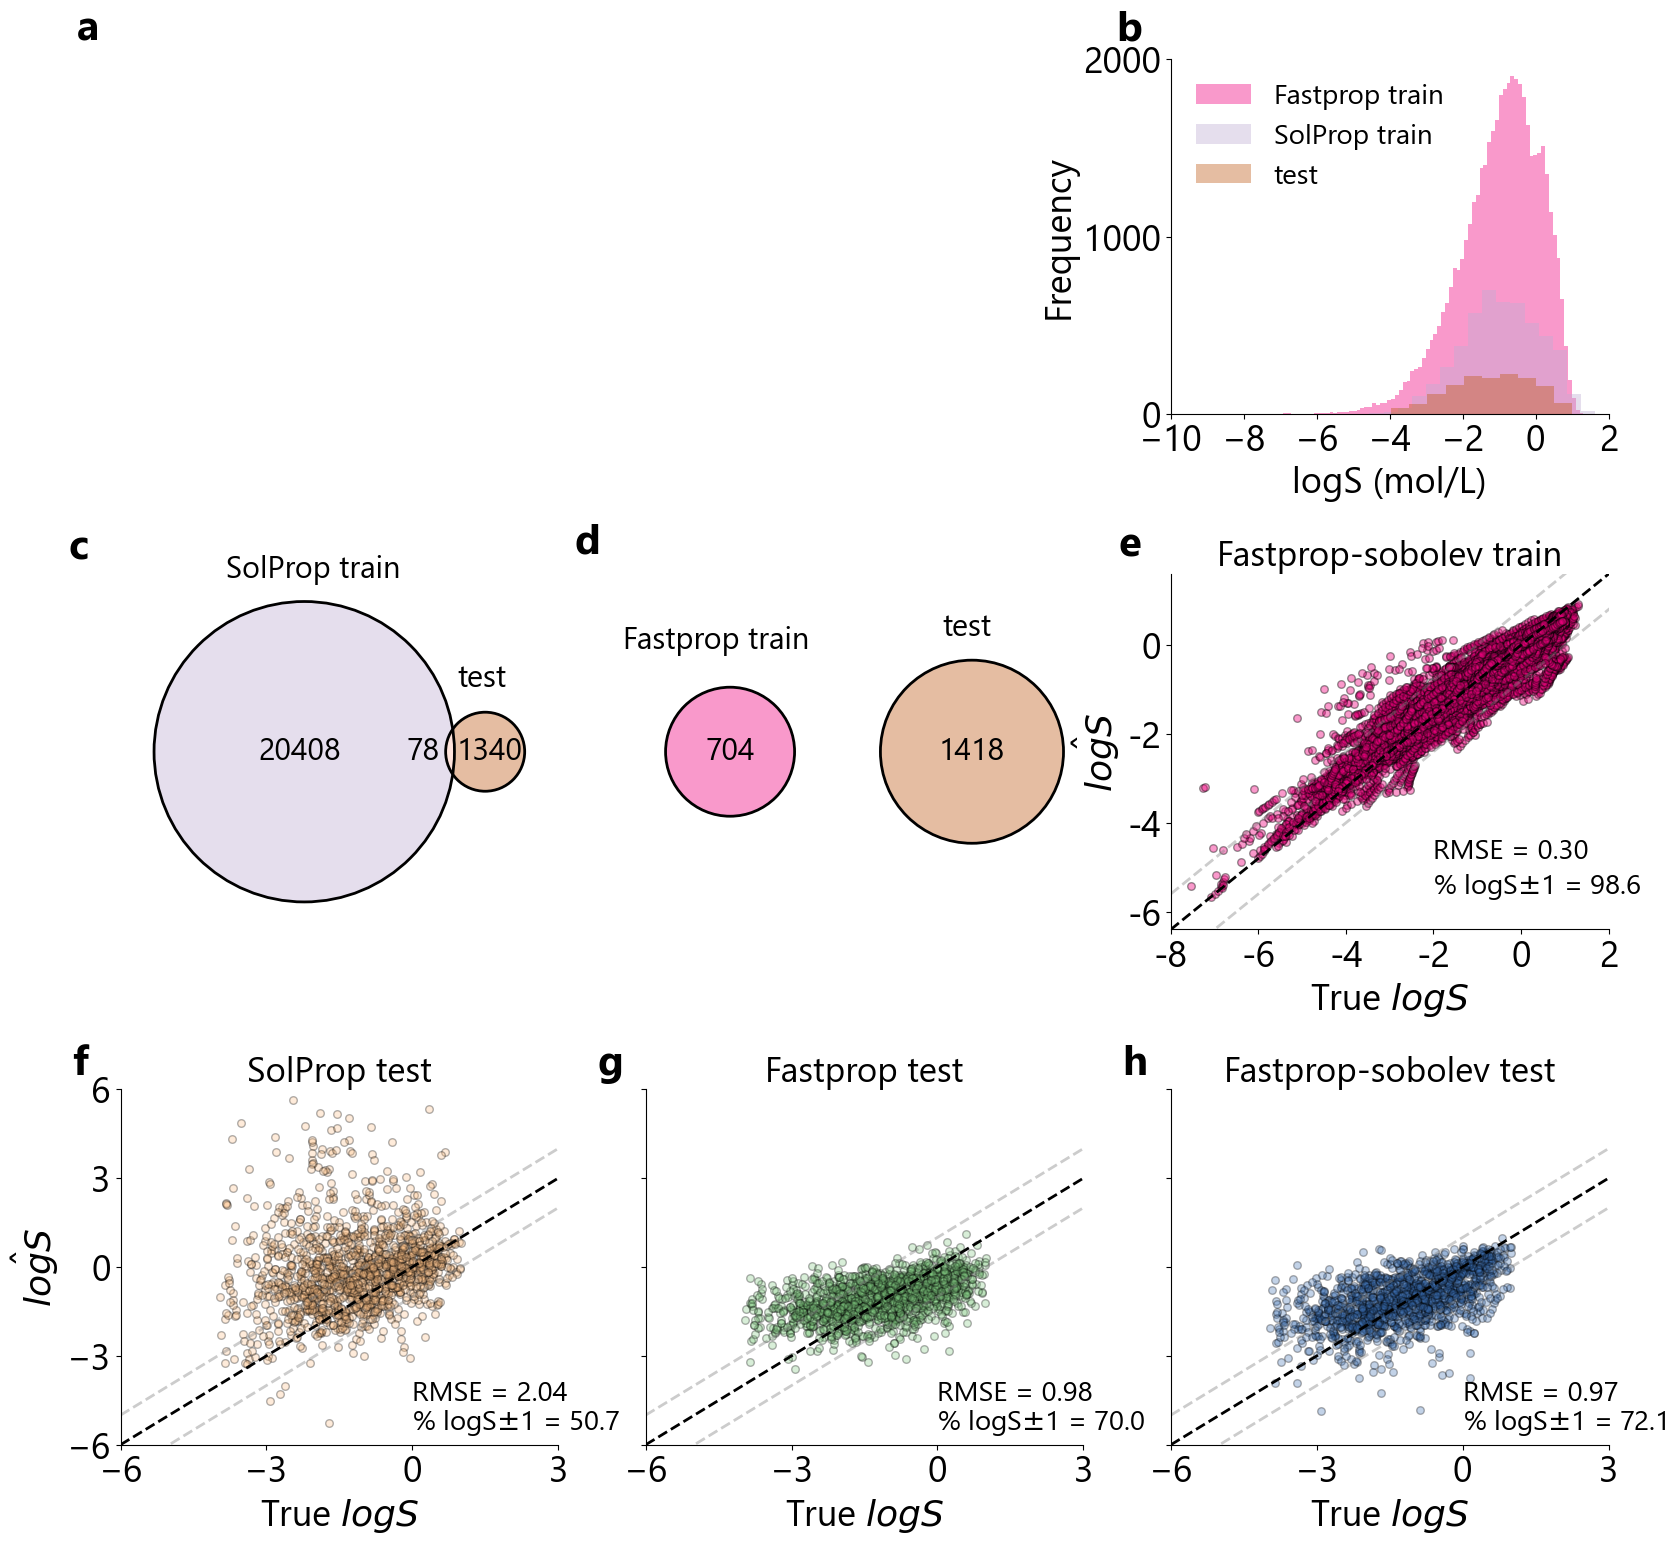

In [32]:
plt.figure(figsize=[6.4*3,4.8*3.75])


ax4 = plt.subplot2grid(shape=(3,3), loc=(1,2), colspan=1)

ax4.plot([-8, 8], [-8,8], linestyle = '--', linewidth = 2, color = 'black')
ax4.plot([-8, 8], [-9,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax4.plot([-8, 8], [-7,9], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax4.scatter(training_performance['logS_true'],training_performance['logS_pred'], alpha =0.4, s = 30, edgecolors = 'black', color = colors[5])

ax4.set_xlim([-8, 2])
ax4.set_xticks([-8, -6, -4, -2, 0, 2])
ax4.set_xticklabels([-8, -6, -4, -2, 0, 2])
ax4.set_ylim([-8,2])
ax4.set_yticklabels([-8, -6, -4, -2, 0, 2])

ax4.set_ylabel(r"$\hat{logS}$")
ax4.set_xlabel(r"True $logS$")
#ax4.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
ax4.spines[['right', 'top']].set_visible(False)
ax4.text(-2,-6, f"RMSE = {np.sqrt(mse_training):.2f}", fontsize = 20)
ax4.text(-2,-7, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_training:.1f}", fontsize = 20)
ax4.set_title("Fastprop-sobolev train", fontsize = 25)
ax4.text(-9.2, 2.5, "e", weight='bold', fontsize = 30)


ax5 = plt.subplot2grid(shape=(3,3), loc=(0,2), colspan=1)

ax5.hist(training_performance['logS_true'], bins=120, color = colors[5], alpha = 0.4, label = 'Fastprop train')
ax5.hist(solprop['logS_true'], bins=20, color = colors[1], alpha = 0.4, label = 'SolProp train')
ax5.hist(leeds_all['logS_true'], bins=10, color = colors[6], alpha = 0.4, label = 'test')


ax5.spines[['top', 'right',]].set_visible(False)
ax5.set_xlabel("logS (mol/L)")
ax5.set_ylabel("Frequency")

ax5.set_xlim([-10, 2])
ax5.set_xticks([-10, -8, -6, -4, -2, 0, 2 ])
ax5.legend(prop={'size': 20}, loc = 'upper left', frameon = False) 
ax5.text(-11.5, 2110, "b", weight='bold', fontsize = 30)
ax5.text(-40, 2110, "a", weight='bold', fontsize = 30)

#plt.ylim([-10, 1200])
#plt.yticks([0, 400, 800, 1200])

ax6 = plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=1)

fig = venn2(
    [set(unique_solutes_solprop_training), set(unique_solutes_leeds)],
    ("SolProp train", "test"),
    set_colors = (colors[1], colors[6]),
    alpha = 0.4,
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
    #subset_areas=(20, 23, 70, 23, 26, 0, 6),
    ax = ax6
)
venn2_circles([set(unique_solutes_solprop_training), set(unique_solutes_leeds)], linewidth=2, ax = ax6)
lbl = fig.get_label_by_id("11")
fig.get_label_by_id("11").set_fontsize(22)
x,y = lbl.get_position()
lbl.set_position((x-0.1, y))


fig.get_label_by_id("A").set_fontsize(22)
lbl = fig.get_label_by_id("A")
x,y = lbl.get_position()
lbl.set_position((x+0.35, y+1.3))

fig.get_label_by_id("B").set_fontsize(22)
lbl = fig.get_label_by_id("B")
x,y = lbl.get_position()
lbl.set_position((x-0.1, y+0.5))

fig.get_label_by_id("01").set_fontsize(22)
fig.get_label_by_id("10").set_fontsize(22)
ax6.text(-0.9, 0.7, "c", weight='bold', fontsize = 30)


ax7 = plt.subplot2grid(shape=(3,3), loc=(1,1), colspan=1)
fig = venn2(
    [set(unique_solutes_krasnov), set(unique_solutes_leeds)],
    ("Fastprop train", "test"),
    set_colors = (colors[5], colors[6]),
    alpha = 0.4, 
    ax = ax7
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
    #subset_areas=(20, 23, 70, 23, 26, 0, 6),
)
venn2_circles([set(unique_solutes_krasnov), set(unique_solutes_leeds)], linewidth=2)

fig.get_label_by_id("A").set_fontsize(22)
lbl = fig.get_label_by_id("A")
x,y = lbl.get_position()
lbl.set_position((x+0.4, y+1))

fig.get_label_by_id("B").set_fontsize(22)
lbl = fig.get_label_by_id("B")
x,y = lbl.get_position()
lbl.set_position((x-0.15, y+1.2))

fig.get_label_by_id("01").set_fontsize(22)
fig.get_label_by_id("10").set_fontsize(22)
ax7.text(-1.6, 1, "d", weight='bold', fontsize = 30)


plt.subplots_adjust(hspace=0.45)
plt.show()
